In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import datetime
import time
import collections
import pandas
import pylab as pl
from pandas.plotting import scatter_matrix
from pylab import *
from tqdm.auto import tqdm

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import pairwise_distances_argmin
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

plt.rcParams["figure.figsize"] = [9, 5]
sns.set(rc={'figure.figsize': (6, 3)})

tqdm.pandas()


In [2]:
class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

## 1. Data Acquistion

### Raw Data Sources:
- Primary Data set: The dataset was downloaded from the Department of Buildings which is responsible for issuing permits for various types of constructions/alterations in the real estate for NY State.

- Secondary Data source: The secondary dataset was taken from NYC Department of Finance for the sales of buildings in NY State from 2016 to 2017 as per the boroughs.

**Zip Code** was used as the Common Key attribute between both these data sources. 




## 2. Data Consolidation

Pandas dataframe was used to consolidate and apply any further data transformations.

### a. Collect data 
### b. Select data 
### c. Integrate data


### Before diving into the data, it was necessary to clean the data to remove the noises and unwanted columns.


In [3]:
%matplotlib inline

## - Primary Datasource

In [4]:
df = pd.read_csv('DOB_Permit_Issuance.csv')
df.shape

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (1,8,9,10,15,25,31,33,34,35,36,51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(3508249, 60)

In [5]:
df.nunique()
df = df[:10000]

### - To find the missing values

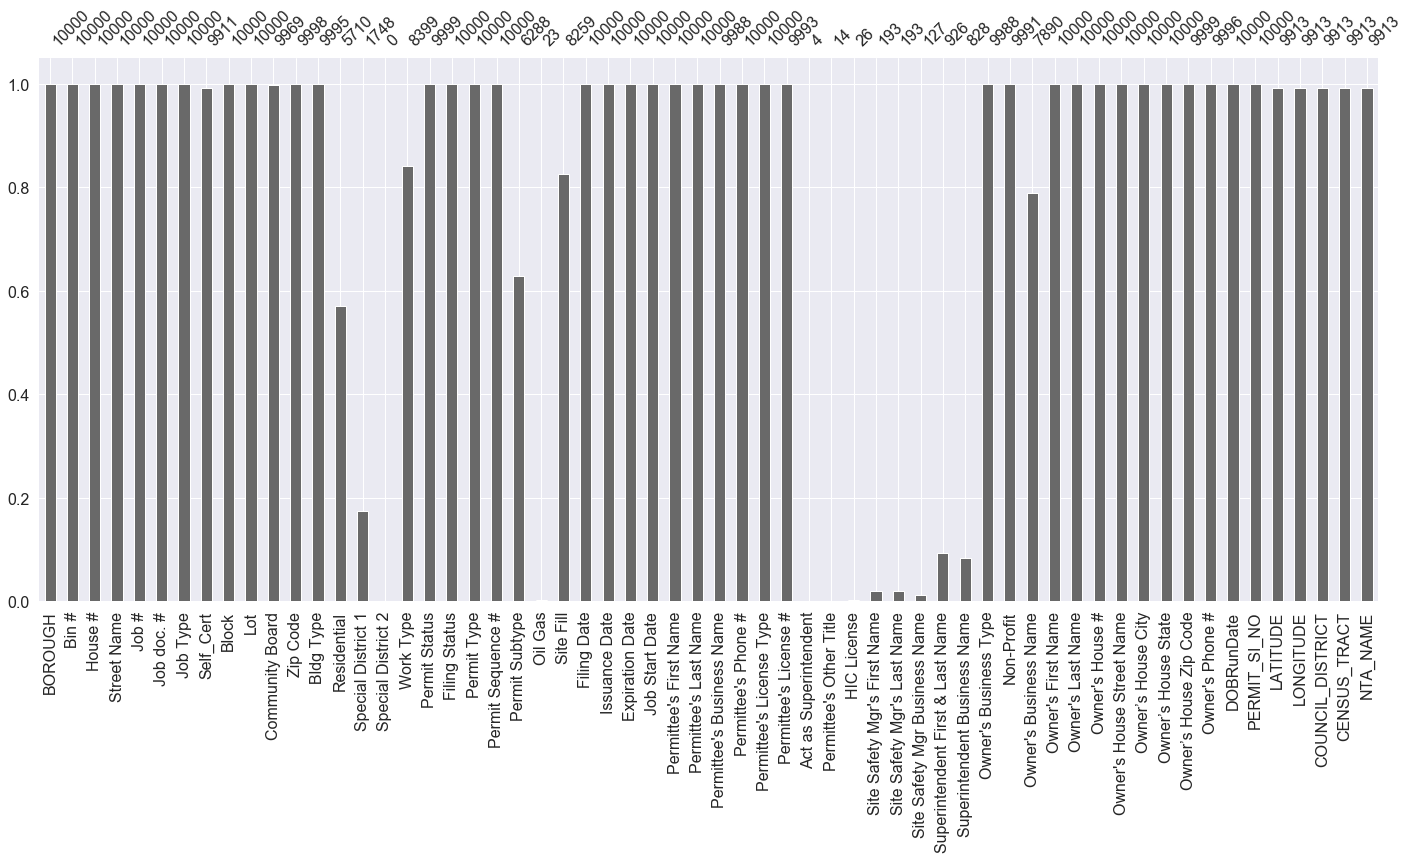

In [6]:
msno.bar(df)

## 3. Data Cleaning


### - a. Reduce noise 
To remove blank values from respectively mentioned columns:

 [Special District 1, Special District 2, Residential, Work Type, Non-profit]

To change data type from float to string for Columns:

  [Special District 1, Special District 2]



In [7]:
df['Special District 1'].fillna('' ,inplace = True)
df['Special District 2'].fillna('' ,inplace = True)
df['Residential'].fillna('', inplace = True)
df['Work Type'].fillna('', inplace = True)

### Rounded off co-ordinates to get lesser precision in order to achieve more discretization and hence reducing noise for the Regressor model.

In [8]:
df['LATITUDE'] = df['LATITUDE'].progress_apply(lambda x: round(x,2))
df['LONGITUDE'] = df['LONGITUDE'].progress_apply(lambda x: round(x,2))

Creating an Attribute through a function to return 1 for values where [Special District 1, Special District 2] are not null.

In [9]:
def special_district(row): 
    if (row['Special District 1'] != '') | (row['Special District 2'] != ''):
        return 1
    else:
        return 0

In [10]:
df['Special District YN'] = df.progress_apply(special_district, axis=1)

### b. Impute values
- Replaced attributes with discrete and numeric values for columns:

    ['Self Cert','Residential','Filing Status', 'Non-Profit']

In [11]:
df['Self_Cert'] = df['Self_Cert'].replace({'Y': 1, 'N': 0}, regex=True)
df['Residential'] = df['Residential'].replace({'YES': 1, '': 0}, regex=True)
df['Filing Status'] = df['Filing Status'].replace({'INITIAL': 0, 'RENEWAL': 1}, regex=True)
df['Non-Profit'] = df['Non-Profit'].replace({True: 1, False: 0}, regex=True)

### c. Eliminate duplicates

In [12]:
df['Bldg Type'] = df['Bldg Type'].replace({1.0: 1, 2.0: 0}, regex=True)

,BOROUGH,Bin #,House #,Street Name,Job #,Job doc. #,Job Type,Self_Cert,Block,Lot,...,Owner’s House Zip Code,Owner's Phone #,DOBRunDate,PERMIT_SI_NO,LATITUDE,LONGITUDE,COUNCIL_DISTRICT,CENSUS_TRACT,NTA_NAME,Special District YN
0,BRONX,2102476,200,E 135TH STREET,240249842,1,A2,1.0,2319,120,...,19355,6.10401e+09,03/27/2019 12:00:00 AM,3608996,40.81,-73.93,8.0,51.0,Mott Haven-Port Morris,0
1,MANHATTAN,1090833,249,WEST 14 STREET,140818435,1,A3,1.0,764,10,...,11101,7.18392e+09,03/27/2019 12:00:00 AM,3609359,40.74,-74.00,3.0,81.0,Hudson Yards-Chelsea-Flatiron-Union Square,0
2,MANHATTAN,1015903,20,WEST 36TH STREET,123372466,2,A2,1.0,837,58,...,10021,2.12249e+09,03/27/2019 12:00:00 AM,3609159,40.75,-73.98,4.0,84.0,Midtown-Midtown South,0
3,QUEENS,4467709,14-30,BROADWAY,421105618,1,A2,1.0,529,2,...,11101,7.18473e+09,03/27/2019 12:00:00 AM,3609358,40.77,-73.93,22.0,45.0,Astoria,0
4,QUEENS,4048873,42-06,108 STREET,421024689,1,A1,0.0,1986,37,...,11368,7.18279e+09,03/27/2019 12:00:00 AM,3606599,40.75,-73.86,21.0,403.0,North Corona,0


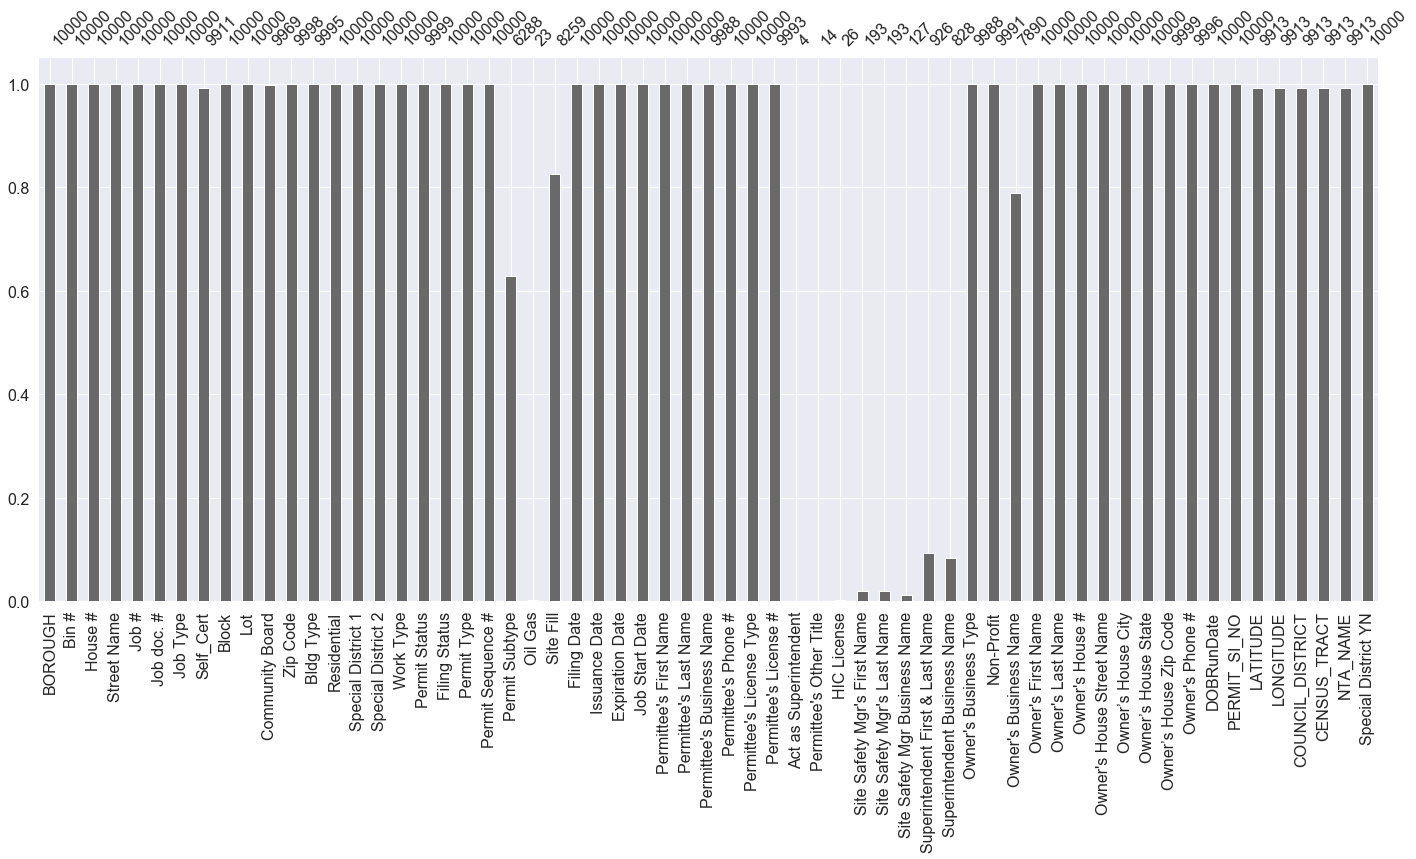

In [13]:
msno.bar(df)
df.head(5)

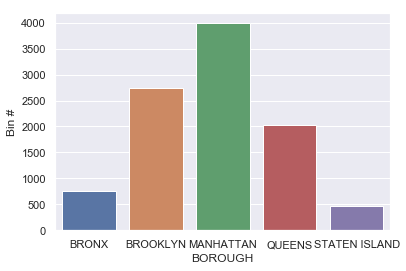

In [28]:
df_temp = df.groupby('BOROUGH')[['Bin #']].count().reset_index()
sns.barplot(x='BOROUGH', y='Bin #', data=df_temp)

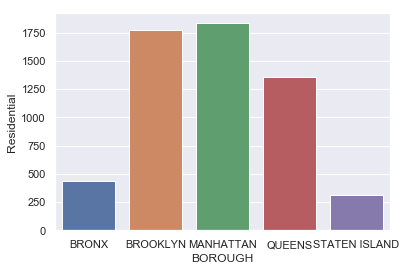

In [29]:
df_resedential_plt = df.groupby('BOROUGH')[['Residential']].sum().reset_index()
sns.barplot(x='BOROUGH', y='Residential', data=df_resedential_plt)


### Exported data into csv to determine the States of Residence for owners who made the maximum purchases of Buildings in NYC


In [15]:
df.groupby(['BOROUGH', 'Owner’s House State'])[['Bin #']].count().sort_values(by='Bin #', ascending=False).unstack(level=0).to_csv('owners_city.csv')

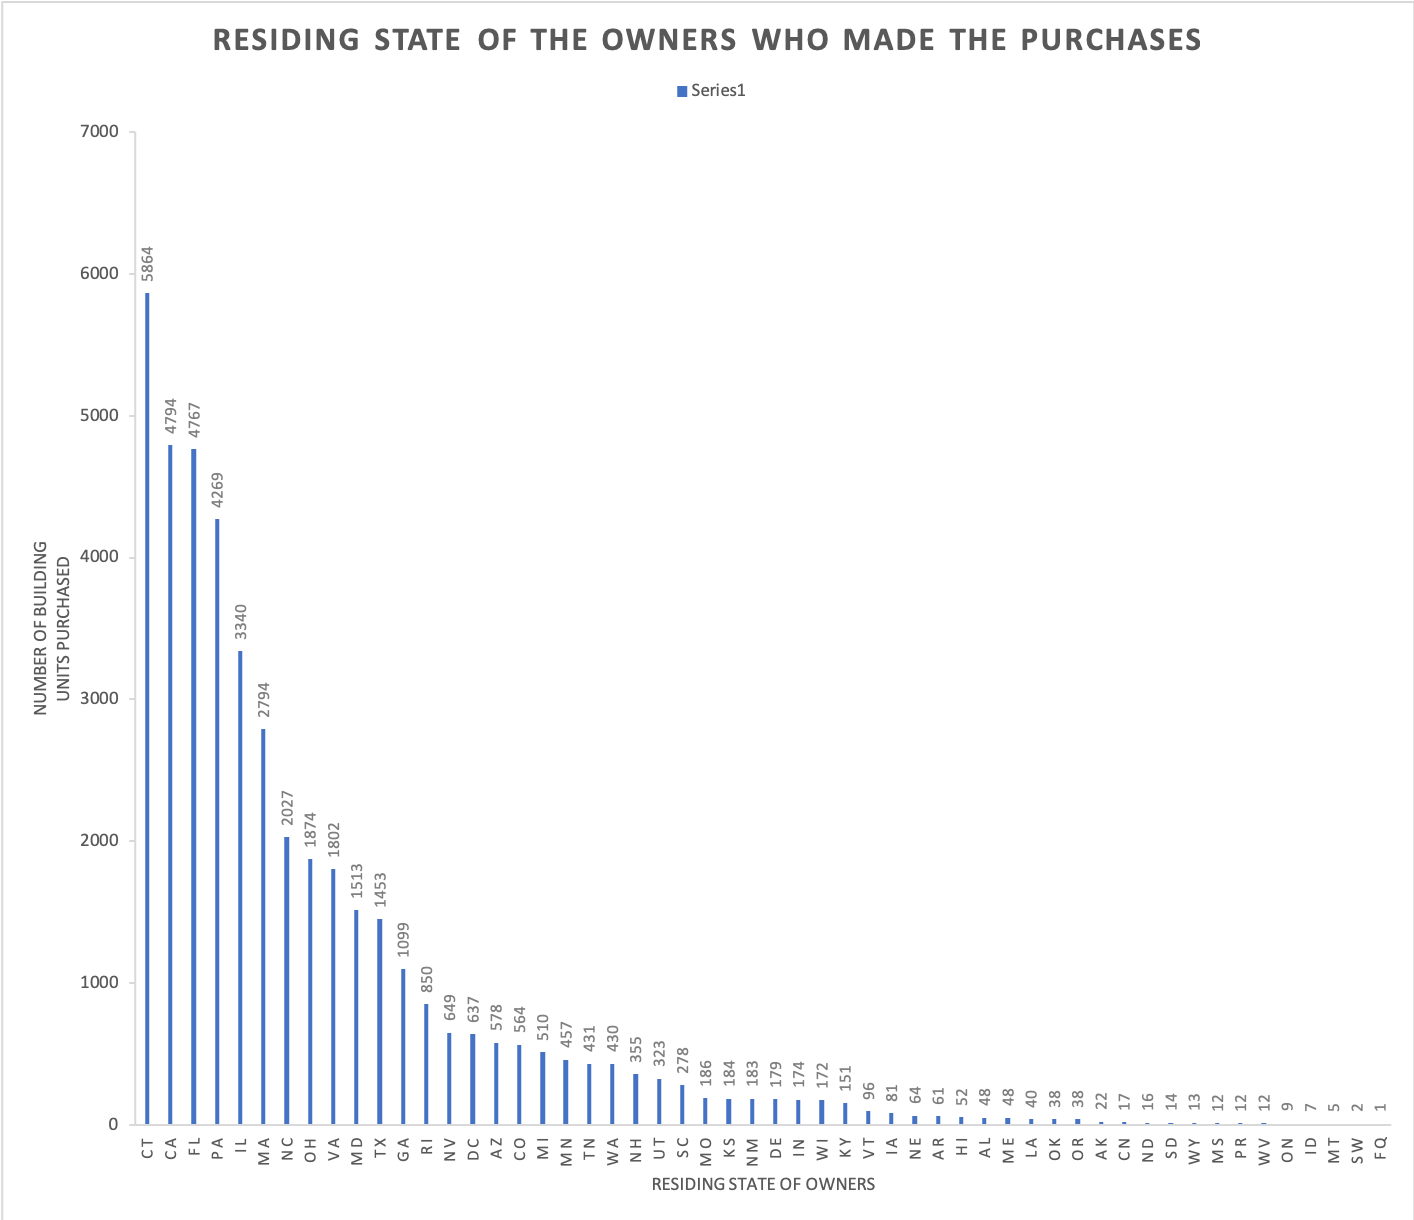

## Secondary Data source

In [16]:
df_real_estate = pd.read_csv('nyc-rolling-sales.csv')

In [17]:
df_real_estate.columns

Index(['Unnamed: 0', 'BOROUGH', 'NEIGHBORHOOD', 'BUILDING CLASS CATEGORY',
       'TAX CLASS AT PRESENT', 'BLOCK', 'LOT', 'EASE-MENT',
       'BUILDING CLASS AT PRESENT', 'ADDRESS', 'APARTMENT NUMBER', 'ZIP CODE',
       'RESIDENTIAL UNITS', 'COMMERCIAL UNITS', 'TOTAL UNITS',
       'LAND SQUARE FEET', 'GROSS SQUARE FEET', 'YEAR BUILT',
       'TAX CLASS AT TIME OF SALE', 'BUILDING CLASS AT TIME OF SALE',
       'SALE PRICE', 'SALE DATE'],
      dtype='object')

In [18]:
df_real_estate = df_real_estate[['SALE PRICE', 'ZIP CODE', 'SALE DATE']]

In [19]:
df_real_estate.columns = ['SALE PRICE', 'Zip Code', 'SALE DATE']

In [20]:
df_real_estate.columns

Index(['SALE PRICE', 'Zip Code', 'SALE DATE'], dtype='object')


## 4. Data Reduction - 
## Merged Primary and Secondary data set to get the key relationships and co-relation between the datasets taking ZIP Code asthe common link.
### a. Reduce Dimensions
### b. Reduce Volume - to reduce run-time 
### c. Data Balancing 

In [21]:
df_final = pd.merge(
    df[['BOROUGH','Self_Cert', 'Zip Code', 'Bldg Type', 'Residential',
        'Work Type', 'Job Type','Permit Status','Filing Status','Permit Type',
        'Permit Subtype','Oil Gas','Site Fill','Non-Profit','LATITUDE','LONGITUDE',
        'CENSUS_TRACT','Special District YN']],
    df_real_estate,
    how='left',
    on=['Zip Code'])

In [22]:
df_final.nunique()

BOROUGH                   5
Self_Cert                 2
Zip Code                205
Bldg Type                 2
Residential               2
Work Type                12
Job Type                  6
Permit Status             2
Filing Status             2
Permit Type               8
Permit Subtype           13
Oil Gas                   2
Site Fill                 5
Non-Profit                2
LATITUDE                 42
LONGITUDE                55
CENSUS_TRACT           1107
Special District YN       2
SALE PRICE             9801
SALE DATE               364
dtype: int64

In [23]:
df_final.dtypes

BOROUGH                 object
Self_Cert              float64
Zip Code               float64
Bldg Type              float64
Residential              int64
Work Type               object
Job Type                object
Permit Status           object
Filing Status            int64
Permit Type             object
Permit Subtype          object
Oil Gas                 object
Site Fill               object
Non-Profit              object
LATITUDE               float64
LONGITUDE              float64
CENSUS_TRACT           float64
Special District YN      int64
SALE PRICE              object
SALE DATE               object
dtype: object

## To encode string into numeric integers

In [24]:
le_dict = {}
for col in df_final.dtypes[df_final.dtypes=="object"].index:
    print(col)
    le_dict[col] = preprocessing.LabelEncoder()
    df_final[col] = le_dict[col].fit_transform(df_final[col].astype(str))

BOROUGH
Work Type
Job Type
Permit Status
Permit Type
Permit Subtype
Oil Gas
Site Fill
Non-Profit
SALE PRICE
SALE DATE


## Hypothesis which is being tested in the random forest regressor model is to predict selling price based on the selected features from the consolidated data set.

In [25]:
def random_forest_regressor(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                        test_size=0.3, 
                                                        random_state=21)
    rf = RandomForestRegressor(n_estimators=500,
                               min_samples_leaf=0.1,
                               random_state=21,
                              n_jobs=-1)
    rf.fit(X_train, y_train)
    return rf

In [26]:
df_final.dropna(inplace=True)

In [27]:
X = df_final.drop(['SALE PRICE','SALE DATE'], axis=1).values
y = df_final['SALE PRICE'].values
rf = random_forest_regressor(X,y)

### To determine the important factors which relates to the selling prices.

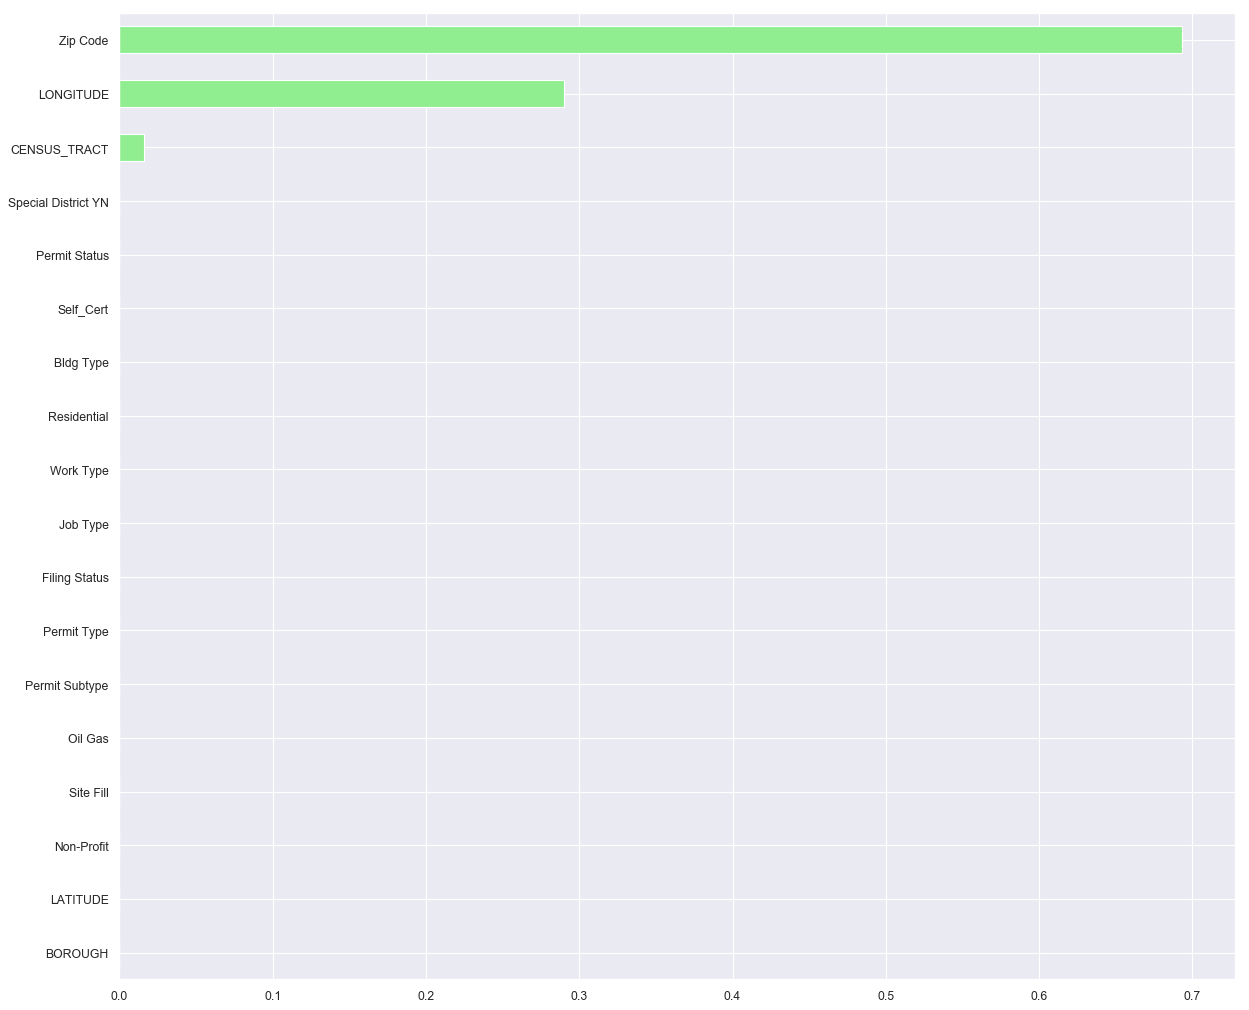

In [27]:
importances_rf = pd.Series(rf.feature_importances_, index = df_final.iloc[:,:-2].columns)
sorted_importances_rf = importances_rf.sort_values()
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
sorted_importances_rf.plot(kind='barh', color='lightgreen')
plt.show()

In [31]:
validation_size = 0.20
seed = 321
X_train, X_validation, Y_train, Y_validation = model_selection.train_test_split(X, y, test_size=validation_size, random_state=seed)
scoring = 'accuracy'

### Imlementing different ML models in order to predict the sales.

In [1]:
models = []
models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(gamma='auto')))

results = []
names = []
for name, model in models:
	kfold = model_selection.KFold(n_splits=10, random_state=seed)
	cv_results = model_selection.cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring, n_jobs=-1)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())

NameError: name 'LogisticRegression' is not defined

In [ ]:
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [ ]:
knn = KNeighborsClassifier()
knn.fit(X_train, Y_train)
predictions = knn.predict(X_validation)
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

In [ ]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(Y_validation, predictions)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

In [ ]:
Nc = range(1, 10)

kmeans = [KMeans(n_clusters=i) for i in Nc]

kmeans

In [ ]:
score = [kmeans[i].fit(Y).score(Y) for i in range(len(kmeans))]

score

pl.plot(Nc,score)

pl.xlabel('Number of Clusters')

pl.ylabel('Score')

pl.title('Elbow Curve')

pl.show()

In [ ]:
def find_clusters(X, n_clusters, rseed=2):
    # 1. Randomly choose clusters
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]
    
    while True:
        # 2a. Assign labels based on closest center
        labels = pairwise_distances_argmin(X, centers)
        
        # 2b. Find new centers from means of points
        new_centers = np.array([X[labels == i].mean(0)
                                for i in range(n_clusters)])
        
        # 2c. Check for convergence
        if np.all(centers == new_centers):
            break
        centers = new_centers
    
    return centers, labels

centers, labels = find_clusters(X, 4)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

In [ ]:
centers, labels = find_clusters(X, 3)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');